In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.preg_aging.cached_reader import get_tests
import os
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.size"] = 14
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12

In [3]:
tests = get_tests(remove_urine=True, remove_percent=True, remove_pct=True)

In [4]:
from src.preg_aging.clalit_parser import group_tests

test_groups = group_tests(tests)

## Quantile change histogram

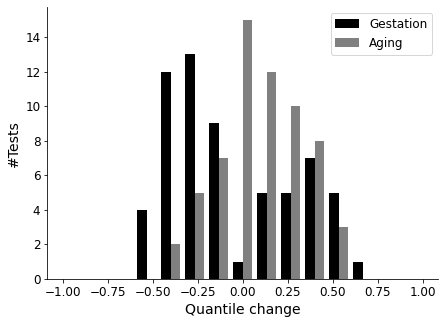

In [5]:
from src.preg_aging.plotting import plot_quantile_diffs_histogram
fig = plot_quantile_diffs_histogram(tests, bins=10)
fig.set_size_inches(7, 5)
# fig.savefig(os.path.join("graphs", "Quantile change histogram.svg"))

## Quartile graphs - change in pregnancy vs. change in aging per system (quantiles)

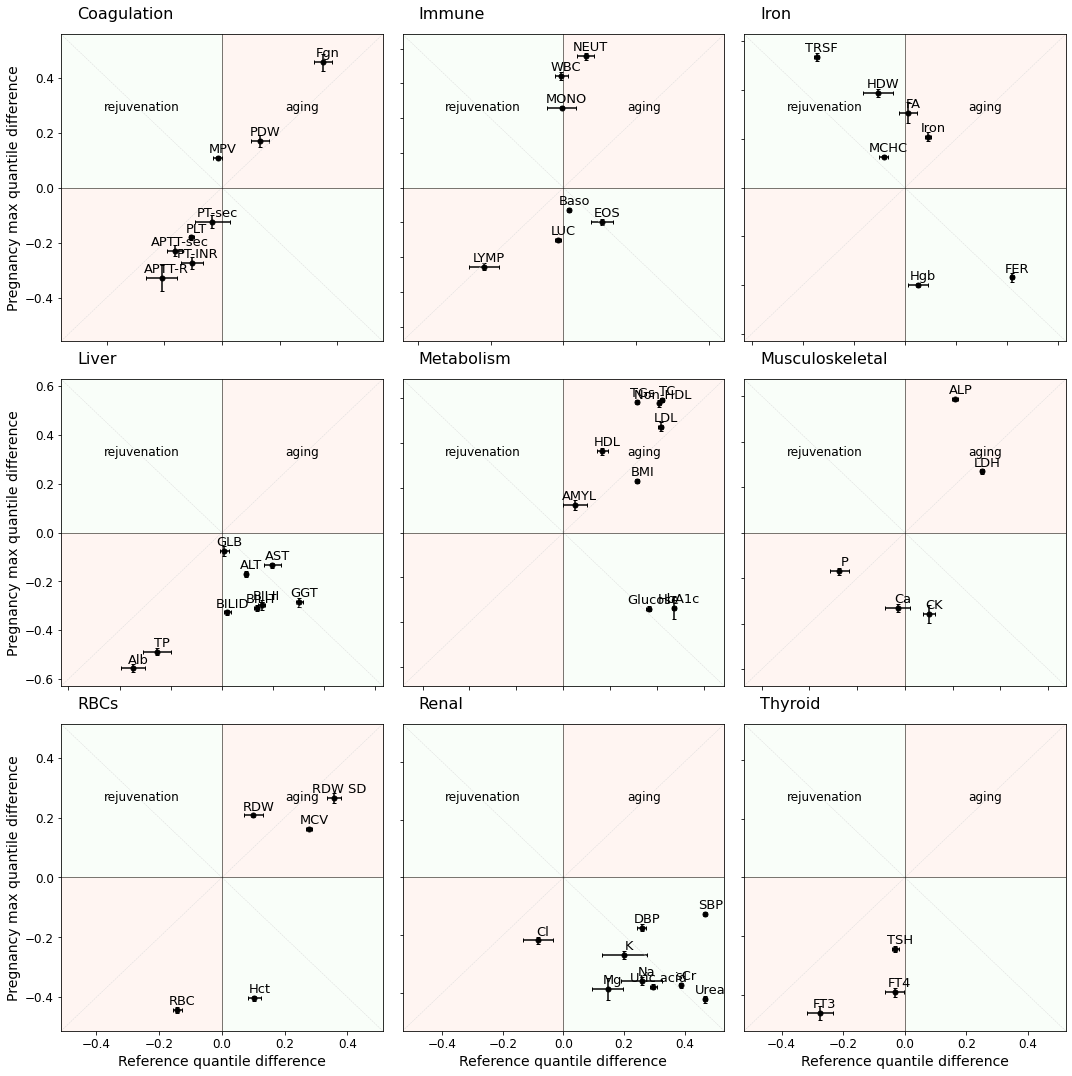

In [6]:
from src.preg_aging.plotting import plot_diff_grid
age_ref = [20, 80]
fig_preg = plot_diff_grid(test_groups, labnorm_age_ref=age_ref, test_period=(-40, -2))
fig_preg.tight_layout()
#fig_preg.savefig(os.path.join("graphs", f"quantile diff, preg_labnorm{str(age_ref)}.svg"))

## Regression training and QA

In [7]:
from src.preg_aging.cached_reader import get_tests
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from src.preg_aging.sample_dataset import resample_per_age, normalize_by_sub_div
tests = get_tests(remove_urine=True, remove_percent=True, remove_pct=True)
complication_tests = get_tests(True, True, True, os.path.join("csvs", "tests_complications.json"))
regression, age = resample_per_age(tests, num_samples_per_age=200)#, range_to_fac={(20,36): 4, (36,71): 1, (71, 100): 3})
normalized_reg = normalize_by_sub_div(regression)
model = OLS(age, add_constant(regression)).fit()
norm_model = OLS(age, add_constant(normalized_reg)).fit()
comp_reg, comp_age = resample_per_age(complication_tests, num_samples_per_age=200)#, range_to_fac={(20,36): 4, (36,71): 1, (71, 100): 3})
comp_model = OLS(comp_age, add_constant(comp_reg)).fit()

### Error exploration

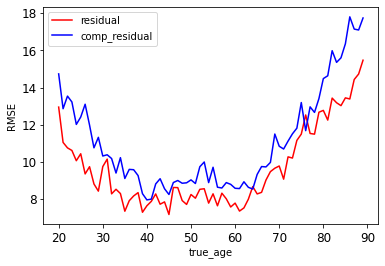

9.902569223031124


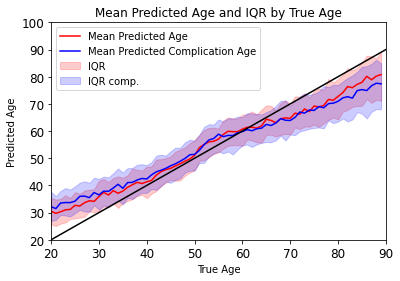

In [8]:
import matplotlib.pyplot as plt
predictions = model.predict(add_constant(regression))
resid = (predictions - age)
predictions_comp = comp_model.predict(add_constant(comp_reg))
comp_resid = (predictions_comp - comp_age)
pred_label_df = pd.DataFrame({"predicted_age": predictions, "true_age": age, "residual": resid ** 2, "predicted_comp_age": predictions_comp, "comp_residual": comp_resid ** 2})
predicted_age_group = pred_label_df.groupby("true_age")[["predicted_age", "predicted_comp_age"]]
mean_predicted_age = predicted_age_group.mean()
mse_plot = (pred_label_df.groupby("true_age")[["residual", "comp_residual"]].mean() ** 0.5).plot(ylabel="RMSE", color=["red", "blue"])
plt.show()
print(pred_label_df["residual"].mean() ** 0.5)

quants = predicted_age_group.quantile([0.25, 0.75])


plt.plot(mean_predicted_age.index, mean_predicted_age["predicted_age"], label='Mean Predicted Age', color='red')
plt.plot(mean_predicted_age.index, mean_predicted_age["predicted_comp_age"], label='Mean Predicted Complication Age', color='blue')
plt.plot([0,100], [0,100], color="k")

plt.fill_between(mean_predicted_age.index, quants.loc[(slice(None), 0.25), "predicted_age"], quants.loc[(slice(None), 0.75), "predicted_age"], color='red', alpha=0.2, label='IQR')
plt.fill_between(mean_predicted_age.index, quants.loc[(slice(None), 0.25), "predicted_comp_age"], quants.loc[(slice(None), 0.75), "predicted_comp_age"], color='blue', alpha=0.2, label='IQR comp.')

# Add labels and legend
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Mean Predicted Age and IQR by True Age')
plt.legend()
plt.xlim(20, 90)
plt.ylim(20, 100)
plt.show()

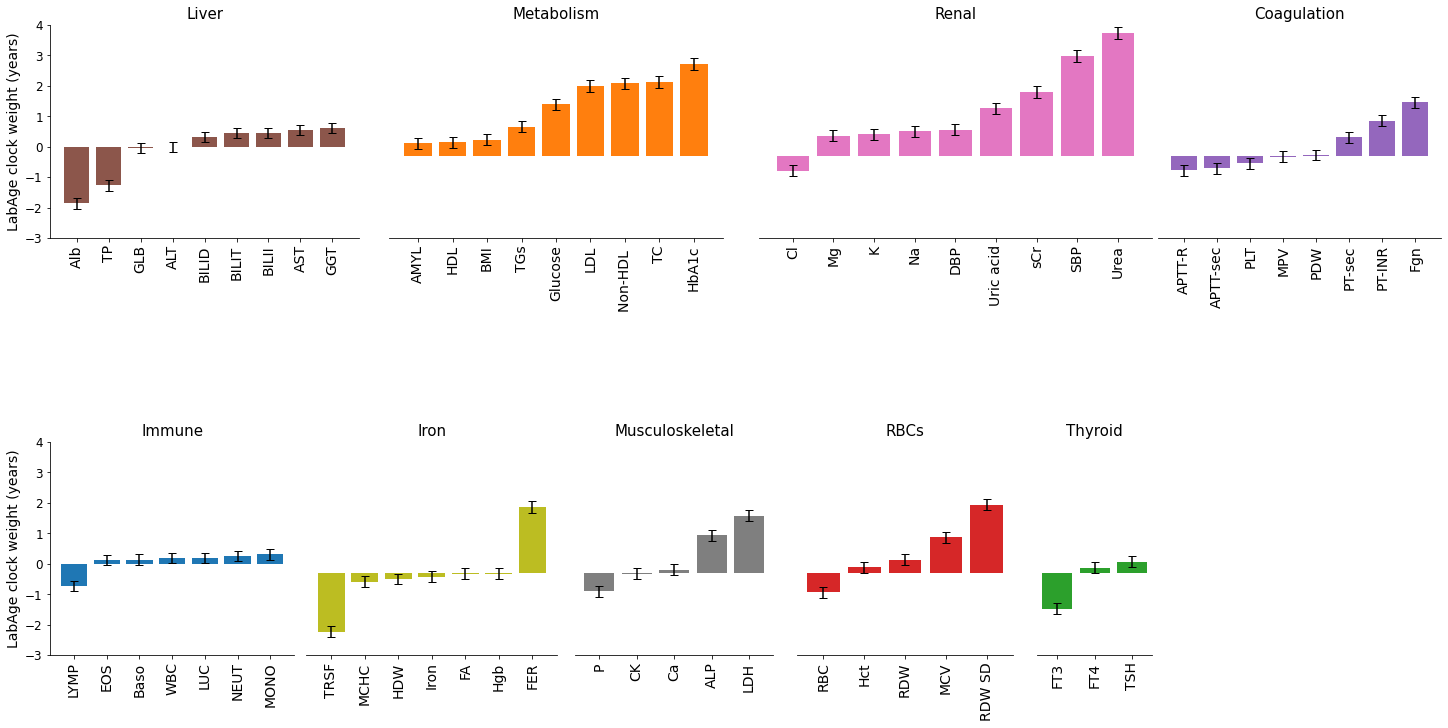

In [9]:
from src.preg_aging.plotting import plot_model_weights
color_map = {'Immune': '#1f77b4', "Metabolism": '#ff7f0e', "Thyroid": '#2ca02c', "RBCs": '#d62728', "Coagulation": '#9467bd', "Liver": '#8c564b', "Renal": '#e377c2', "Musculoskeletal": '#7f7f7f', "Iron": '#bcbd22'}
f = plot_model_weights(test_groups, norm_model, color_map, 4, (-2.5,4.))
# f.savefig(os.path.join("graphs", "model_weights.svg"))
# f.savefig(os.path.join("graphs", "model_weights.png"), dpi=150)

## Regression predictions

<Figure size 432x288 with 0 Axes>

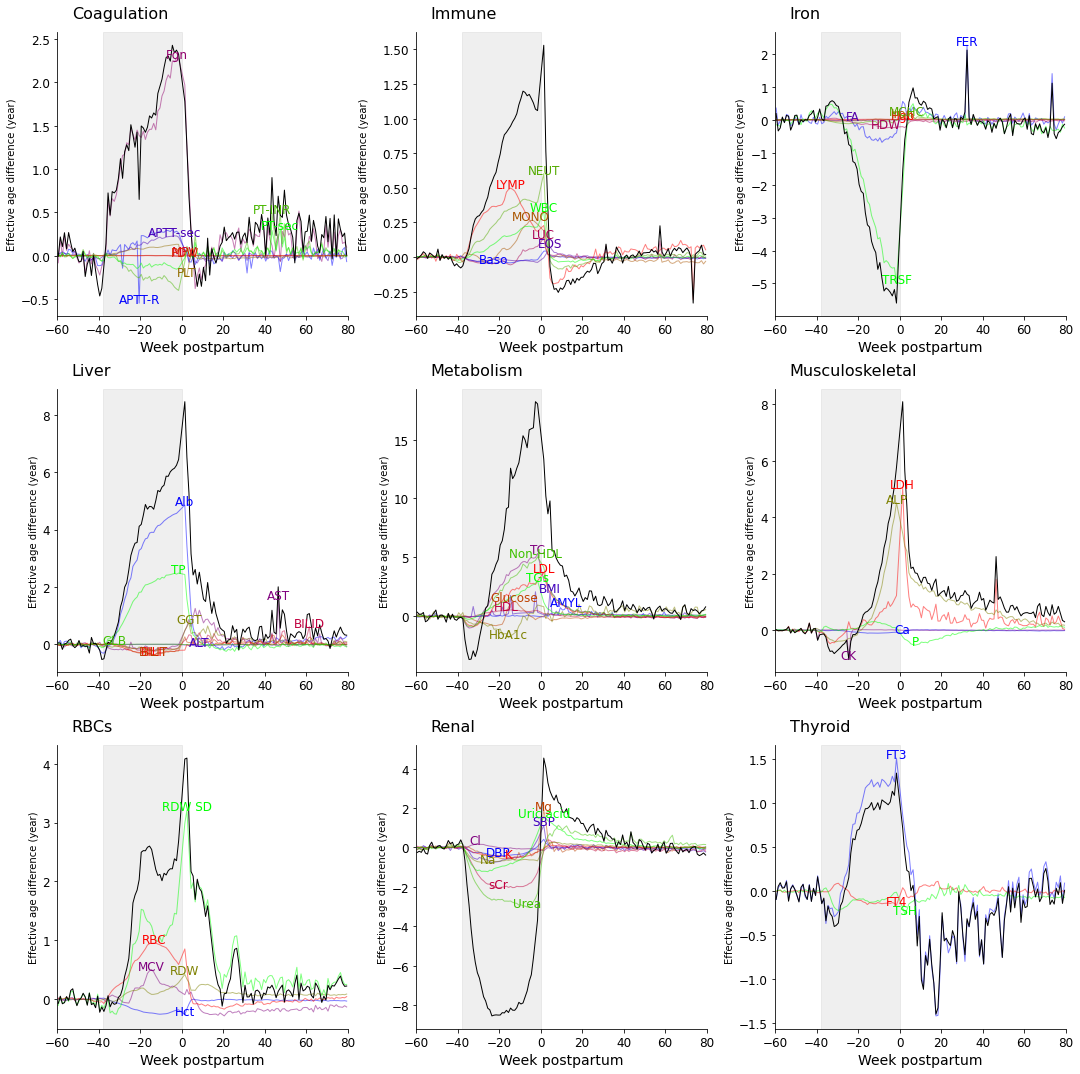

In [10]:
from src.preg_aging.plotting import plot_groups_linear_prediction
plt.clf()
test_groups_rbc_comp = test_groups.copy()
fig = plot_groups_linear_prediction(test_groups, model.params, skip_range=(-1., 1.), colormap="brg")
plt.tight_layout()
# fig.savefig(os.path.join("graphs", "system_by_system_prediction.svg"))

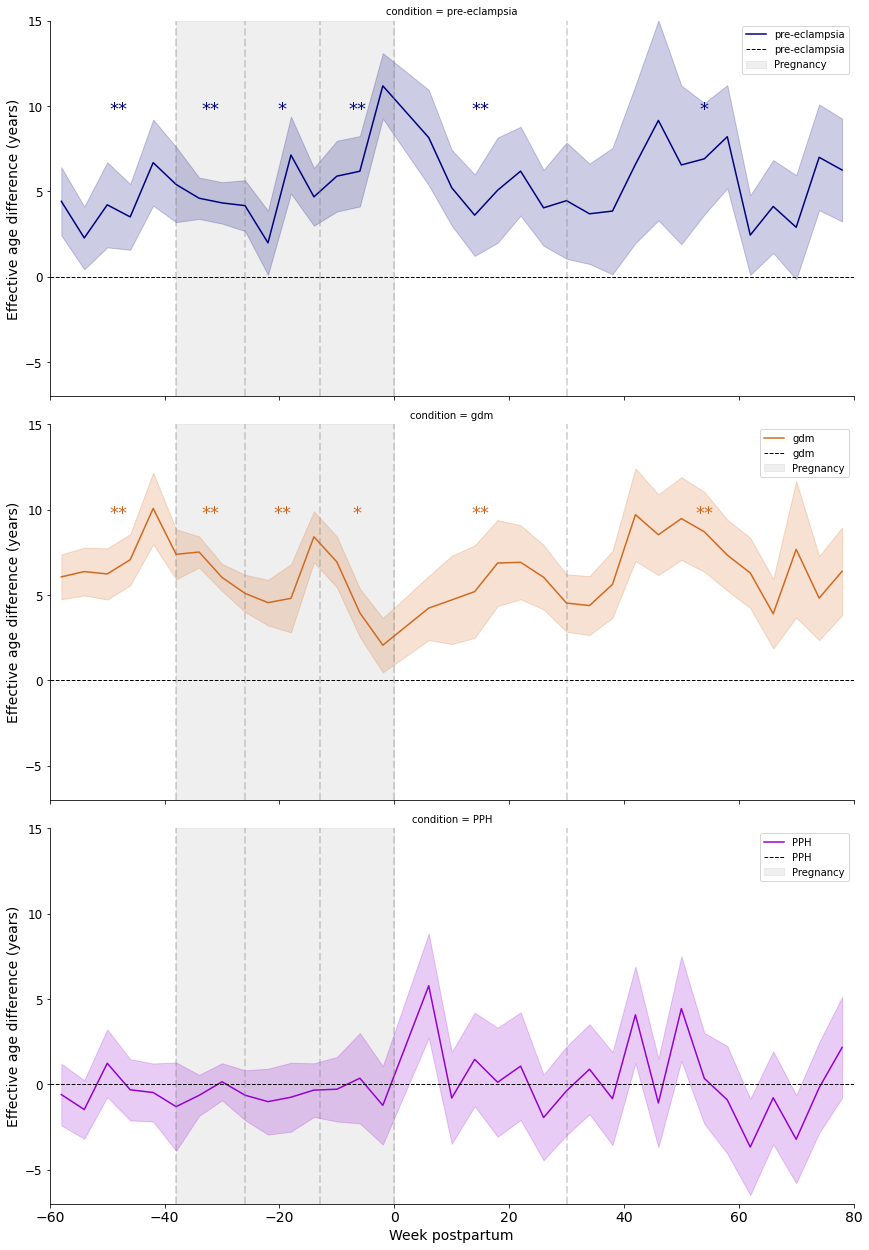

In [11]:
from src.preg_aging.plotting import plot_age_acceleration_by_lin_reg
fig = plot_age_acceleration_by_lin_reg(comp_model,
                                       [r".\csvs\pregnancy.pre-eclampsia.4w",
                                        r".\csvs\pregnancy.gdm.4w",
                                        r".\csvs\pregnancy.postpartum_hemorrhage.4w"],
                                       r".\csvs\pregnancy.4w",
                                       exclude_points=[2], compared_color_map={r"pre-eclampsia": "navy",
                                                                               "gdm": "chocolate",
                                                                               "PPH": "darkviolet"},
                                       p_val_bins=[-58, -38, -26, -13, 0, 30, 78], use_fill=True, y_limit=(-7., 15.),
                                       y_ticks=[-5, 0, 5, 10, 15], fix_outliers=True)

# fig.savefig(os.path.join("graphs", "age_acceleration_comp_5_diff.svg"))


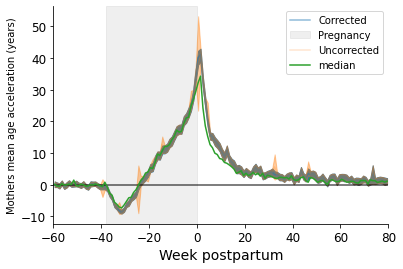

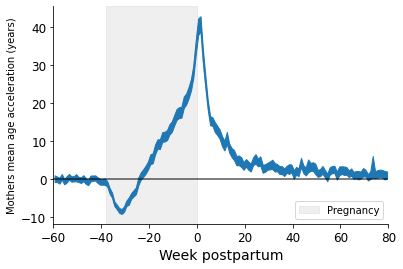

In [12]:
from src.preg_aging.plotting import plot_model_prediction
from src.preg_aging.clalit_parser import get_clalit_data
f, ax = plot_model_prediction(model, fix_outliers=True, use_fill=True, label="Corrected")
plot_model_prediction(model, use_fill=True, ax=ax, label="Uncorrected", alpha=0.2)
pred_median = add_constant(pd.DataFrame({test: get_clalit_data(test)["val_50"] for test in tests})) @ model.params
pred_median -= pred_median.loc[-60:-40].mean()
ax.plot(pred_median.index, pred_median.values, label="median")
ax.legend()
# f.savefig(os.path.join("graphs", "pregnancy_pred_full.svg"))
display(f)
####
plt.clf()
f, ax = plot_model_prediction(model, fix_outliers=True, use_fill=True)
# f.savefig(os.path.join("graphs", "pregnancy_pred.svg"))

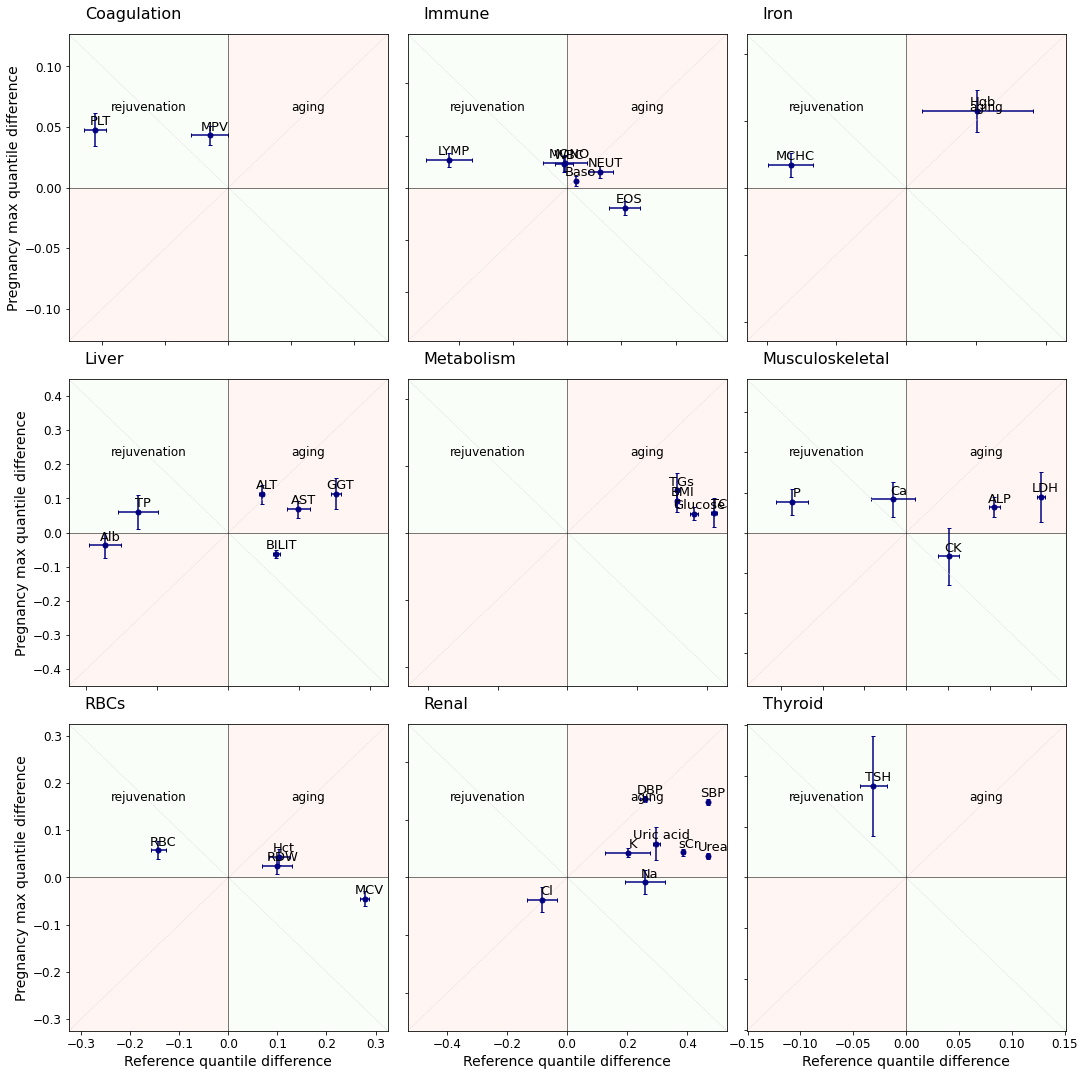

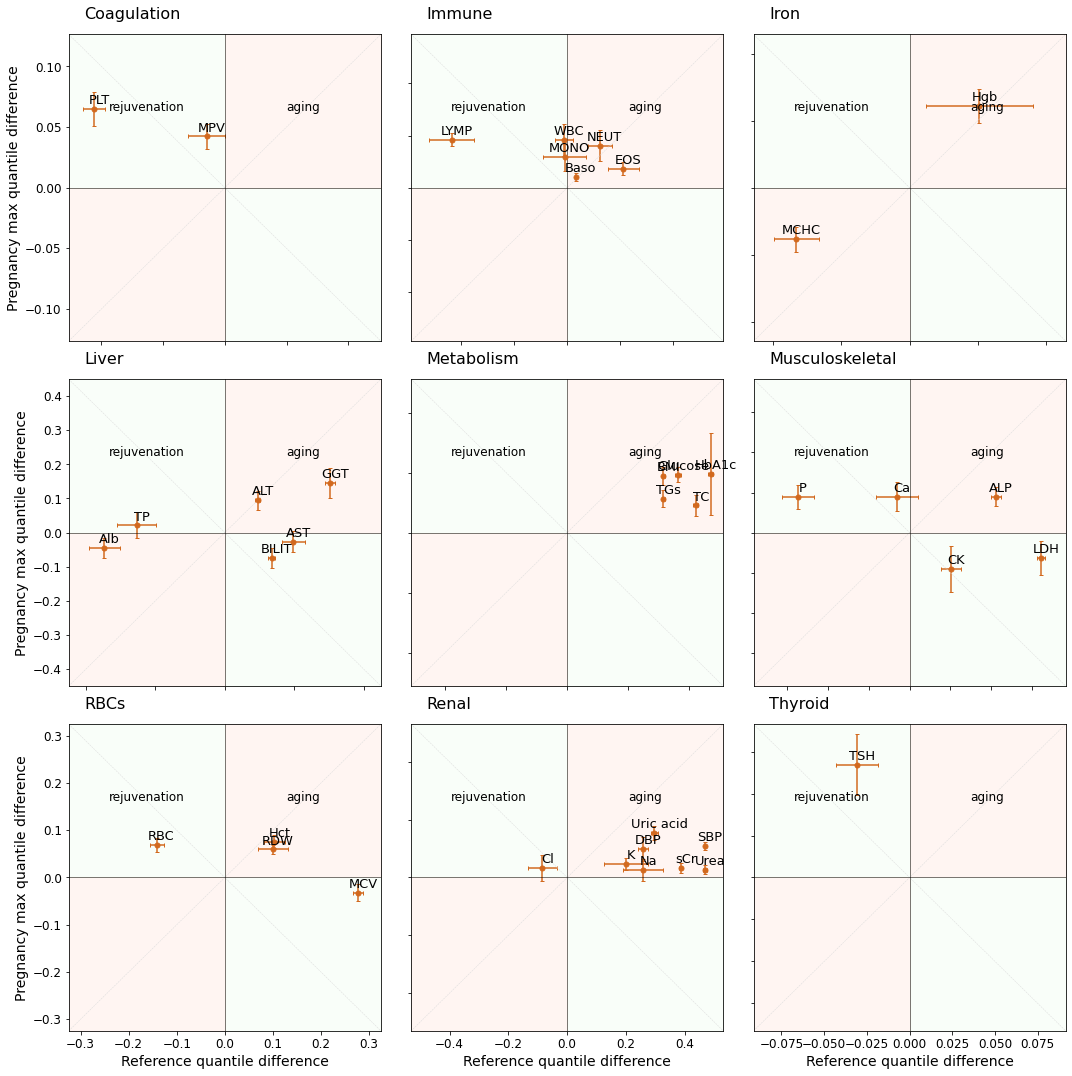

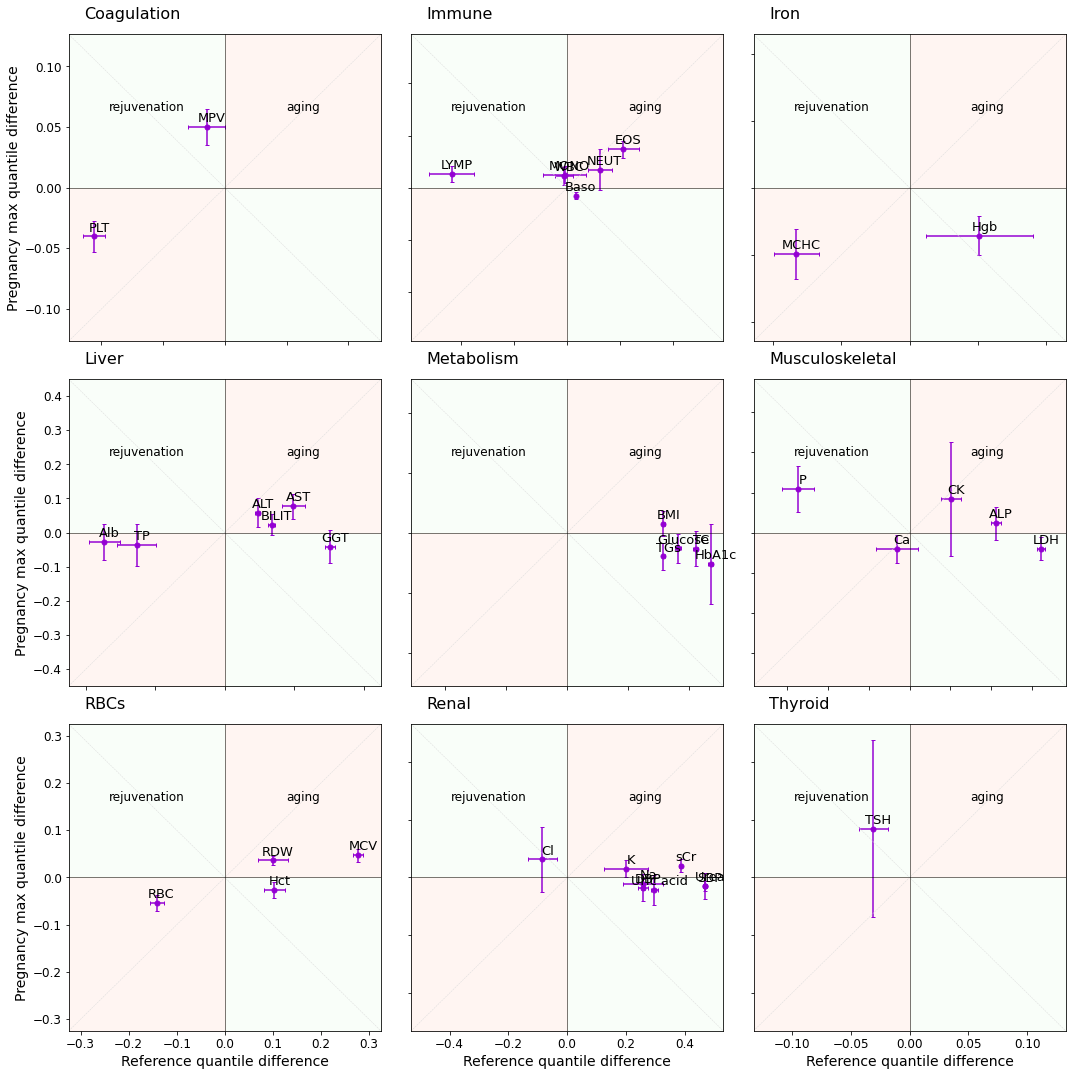

In [13]:
from src.preg_aging.plotting import plot_diff_grid_pathologies
complications_group = group_tests(complication_tests)
fig = plot_diff_grid_pathologies(complications_group,
                                 r".\csvs\pregnancy.pre-eclampsia.4w",
                                 r".\csvs\pregnancy.4w", color="navy")
plt.tight_layout()
# fig.savefig(os.path.join("graphs", "quantile diff, preecl.svg"))

fig = plot_diff_grid_pathologies(complications_group, r".\csvs\pregnancy.gdm.4w",
                                 r".\csvs\pregnancy.4w", color="chocolate")
plt.tight_layout()
# fig.savefig(os.path.join("graphs", "quantile diff, gdm.svg"))

fig = plot_diff_grid_pathologies(complications_group,
                                 r".\csvs\pregnancy.postpartum_hemorrhage.4w",
                                 r".\csvs\pregnancy.4w", color="darkviolet")
plt.tight_layout()
# fig.savefig(os.path.join("graphs", "quantile diff, pph.svg"))

## Regression weight visualization

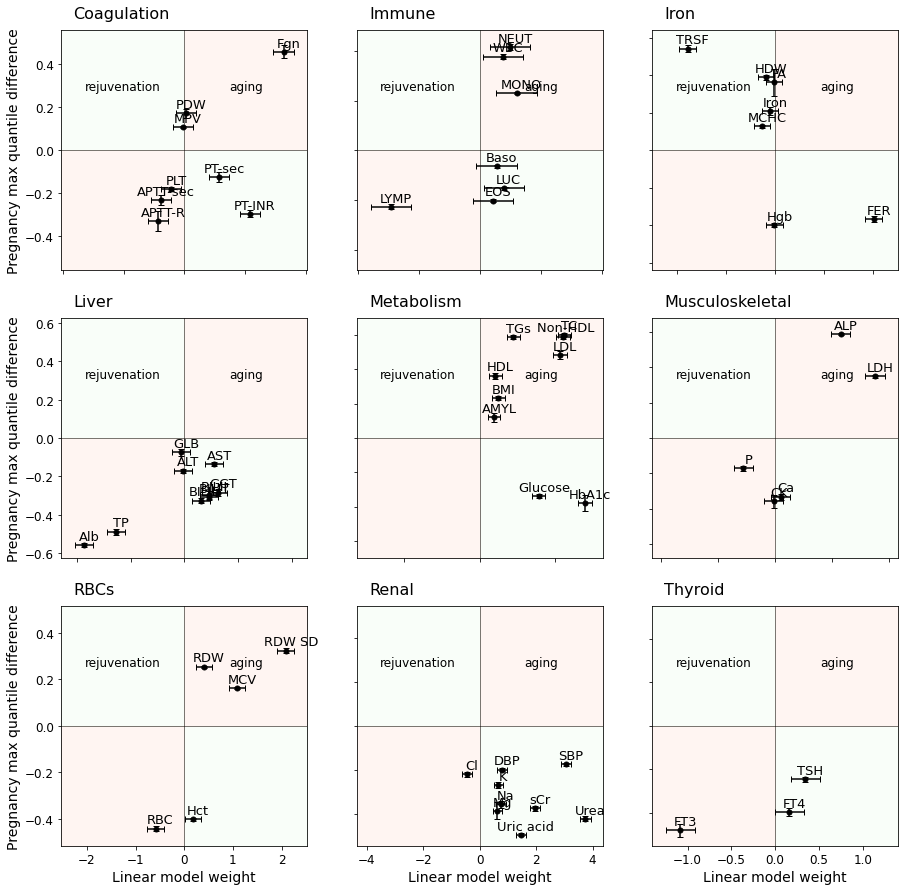

In [14]:
from src.preg_aging.plotting import plot_diff_grid_model_weights
_ = plot_diff_grid_model_weights(test_groups, norm_model)

## Check high varaince

In [15]:
from src.preg_aging.clalit_parser import get_clalit_data
import pandas as pd
s = pd.Series(data=-1, index=tests, dtype=float, name="SEM ratio")
for t in tests:
    df = get_clalit_data(t)
    df = df.loc[~df.index.isin([-0.5, 0.5])]
    sem = df["val_sd"] / df["val_n"] ** 0.5
    s.loc[t] = sem.max() / sem.median()
(s  * 1).sort_values(ascending=False, key=abs)

CK_CREAT            279.192052
BMI                 126.405075
LYMP                 29.648884
FERRITIN             23.534697
APTT_R               18.679031
                       ...    
MPV                   1.317459
RDW                   1.313888
GLOBULIN              1.310586
MCV                   1.303323
PHOSPHORUS_BLOOD      1.165880
Name: SEM ratio, Length: 62, dtype: float64